In [2]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# -----------------------------
# 1. Custom Elevator Environment
# -----------------------------
class ElevatorMultiStopEnv(gym.Env):
    def __init__(self, num_floors=10):
        super(ElevatorMultiStopEnv, self).__init__()
        self.num_floors = num_floors
        self.observation_space = spaces.Box(low=0, high=1, shape=(1+num_floors,), dtype=np.int32)
        self.action_space = spaces.Discrete(num_floors)
        self.reset()

    def encode_state(self):
        return np.concatenate(([self.current_floor], self.requests_vector))

    def step(self, action):
        reward = 0
        if self.requests_vector[action] == 0:
            reward = -1  # Penalty for unnecessary stop
        else:
            travel_cost = abs(self.current_floor - action)
            reward = 10 - travel_cost  # Reward inversely proportional to travel cost
            self.current_floor = action
            self.requests_vector[action] = 0  # Serve request

        if np.sum(self.requests_vector) == 0:
            self.done = True
            reward += 50  # Bonus for completing all requests

        return self.encode_state(), reward, self.done, {}

    def reset(self):
        self.current_floor = np.random.randint(0, self.num_floors)
        num_requests = np.random.randint(1, 4)
        self.requests = sorted(random.sample(range(self.num_floors), num_requests))
        self.requests_vector = np.zeros(self.num_floors, dtype=np.int32)
        for r in self.requests:
            self.requests_vector[r] = 1
        self.done = False
        return self.encode_state()

# -----------------------------
# 2. Q-learning Agent
# -----------------------------
NUM_FLOORS = 10
STATE_SPACE_SIZE = NUM_FLOORS * (2 ** NUM_FLOORS)

def encode_state_to_index(state):
    current_floor = int(state[0])
    binary_val = 0
    for bit in state[1:]:
        binary_val = (binary_val << 1) | int(bit)
    return current_floor * (2 ** NUM_FLOORS) + binary_val

Q_table = np.zeros((STATE_SPACE_SIZE, NUM_FLOORS))

# Hyperparameters
alpha = 0.1         # Learning rate
gamma = 0.95        # Discount factor
epsilon = 1.0       # Initial exploration rate
epsilon_decay = 0.995
min_epsilon = 0.01
num_episodes = 5000

env = ElevatorMultiStopEnv(num_floors=NUM_FLOORS)
reward_list = []

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    state_idx = encode_state_to_index(state)
    total_reward = 0

    while True:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state_idx])

        next_state, reward, done, _ = env.step(action)
        next_state_idx = encode_state_to_index(next_state)

        best_next_action = np.argmax(Q_table[next_state_idx])
        td_target = reward + gamma * Q_table[next_state_idx, best_next_action]
        Q_table[state_idx, action] += alpha * (td_target - Q_table[state_idx, action])

        state_idx = next_state_idx
        total_reward += reward

        if done:
            break

    # ✅ Epsilon decay after each episode
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    reward_list.append(total_reward)

    # Debug log
    if (episode + 1) % 500 == 0 or episode < 5:
        print(f"Episode {episode+1}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.5f}")

print("Training completed!")



Episode 1, Total Reward: 52.00, Epsilon: 0.99500
Episode 2, Total Reward: 62.00, Epsilon: 0.99003
Episode 3, Total Reward: 53.00, Epsilon: 0.98507
Episode 4, Total Reward: 46.00, Epsilon: 0.98015
Episode 5, Total Reward: 51.00, Epsilon: 0.97525
Episode 500, Total Reward: 58.00, Epsilon: 0.08157
Episode 1000, Total Reward: 65.00, Epsilon: 0.01000
Episode 1500, Total Reward: 63.00, Epsilon: 0.01000
Episode 2000, Total Reward: 64.00, Epsilon: 0.01000
Episode 2500, Total Reward: 68.00, Epsilon: 0.01000
Episode 3000, Total Reward: 60.00, Epsilon: 0.01000
Episode 3500, Total Reward: 59.00, Epsilon: 0.01000
Episode 4000, Total Reward: 57.00, Epsilon: 0.01000
Episode 4500, Total Reward: 56.00, Epsilon: 0.01000
Episode 5000, Total Reward: 59.00, Epsilon: 0.01000
Training completed!


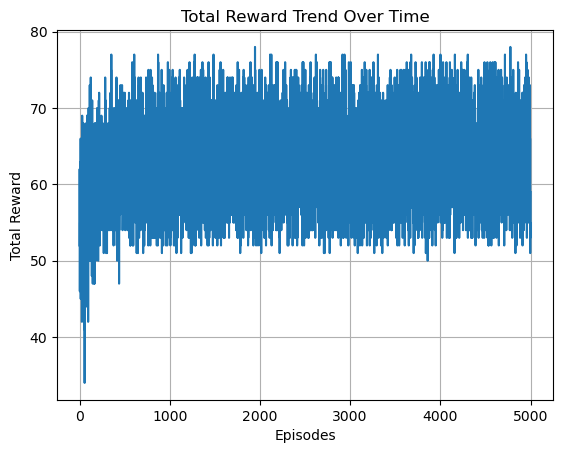

In [3]:
# Plot Total Reward Trend
plt.plot(reward_list)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Total Reward Trend Over Time")
plt.grid(True)
plt.show()


In [5]:
#  Elevator Simulation & Animation

def simulate_elevator(start_floor, requested_floors):
    env = ElevatorMultiStopEnv(num_floors=NUM_FLOORS)
    env.current_floor = start_floor
    env.requests = sorted(requested_floors)
    env.requests_vector = np.zeros(NUM_FLOORS, dtype=np.int32)
    for r in env.requests:
        env.requests_vector[r] = 1
    env.done = False

    state_idx = encode_state_to_index(env.encode_state())
    elevator_positions = [start_floor]

    while not env.done:
        action = np.argmax(Q_table[state_idx])  # Use trained policy
        next_state, _, done, _ = env.step(action)
        state_idx = encode_state_to_index(next_state)
        elevator_positions.append(env.current_floor)

    return elevator_positions

Enter starting floor (0-9): 3
Enter requested floors separated by space (0-9): 0 2 5
Optimized Path: [3, 0, 2, 5]


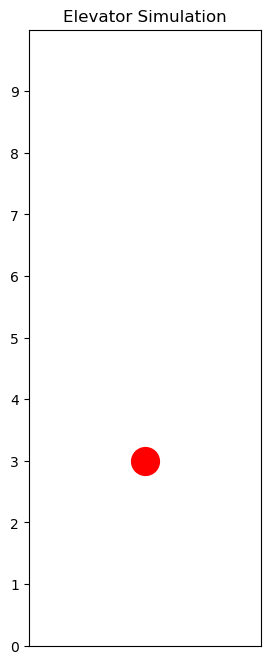

In [8]:
# User input for simulation
start_floor = int(input("Enter starting floor (0-9): "))
requested_floors = list(map(int, input("Enter requested floors separated by space (0-9): ").split()))

# Run simulation
optimized_path = simulate_elevator(start_floor, requested_floors)
print("Optimized Path:", optimized_path)

# Animation
fig, ax = plt.subplots(figsize=(3, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, NUM_FLOORS)
elevator, = ax.plot([0.5], [start_floor], "ro", markersize=20)

def update(frame):
    elevator.set_ydata([optimized_path[frame]])
    return elevator,

ani = animation.FuncAnimation(fig, update, frames=len(optimized_path), interval=1000, repeat=False)

plt.xticks([])
plt.yticks(range(NUM_FLOORS))
plt.title("Elevator Simulation")
plt.show()